In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install geometric_kernels

# If you want to use a version of the library from a specific branch on GitHub,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/geometric-kernels/GeometricKernels@devel"

# Matérn and Heat Kernels on (Oriented) Graphs
This notebook shows how to define and evaluate kernels on the edge space of an oriented simple graph.
By this we mean kernels $k: E \times E \to \mathbb{R}$ where $E$ is a vertex set of a graph.
The graph **must be** undirected and we assign user-chosen orientations for the edges.

At the very end of the notebook we also show how to construct *approximate finite-dimensional feature maps* for the kernels on the edge space of graphs and how to use these to efficiently sample the Gaussian processes $\mathrm{GP}(0, k)$.

We use the **PyTorch** backend here.

**Important:** the goal of these kernels are to model the covariance between edges for the flow-type data, e.g., water flows, information flows. The original paper [Yang et al. 2024](https://arxiv.org/abs/2310.19450) has modelled edge flows and built Hodge-compositional kernels for them, particularly on the edge space of **simplicial 2-complexes**. Here we only consider the edge space of graphs, which is a special case of **simplicial 1-complexes**. For the general case, please refer to the original paper, as well as the [code](https://github.com/cookbook-ms/Hodge-Edge-GP).

<!--TABLE OF CONTENTS-->
## Contents
- [**Basics**](#Basics)
  - [Defining a Space](#Defining-a-Space)
  - [Defining a Kernel](#Defining-a-Kernel)
  - [Evaluating Kernels on Random Inputs](#Evaluating-Kernels-on-Random-Inputs)
  - [Visualizing Kernels](#Visualizing-Kernels)
  - [A Note on Prior Variance](#A-Note-on-Prior-Variance)
- [**Feature Maps and Sampling**](#Feature-Maps-and-Sampling)
  - [Defining a Feature Map](#Defining-a-Feature-Map)
  - [Efficient Sampling using Feature Maps](#Efficient-Sampling-using-Feature-Maps)
- [**Citation**](#Citation)

## Basics

In [2]:
# Import a backend, we use torch in this example.
import torch
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
import geometric_kernels.torch
# from geometric_kernels import jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces.graph_edge import GraphEdge
from geometric_kernels.kernels import MaternGeometricKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.
INFO (geometric_kernels): Torch backend enabled.


### Defining a Space

First we create and visualize a simple *5-node, 6-edge graph* using `networkx`

In [3]:
G = nx.Graph()
G.add_edge(1, 2)
G.add_edge(1, 3)
G.add_edge(1, 5)
G.add_edge(2, 3)
G.add_edge(3, 4)
G.add_edge(4, 5)


Define the positions of the nodes

In [4]:
# explicitly set positions
pos = {1: (0, 0), 2: (-1, 0.3), 3: (2, 0.17), 4: (4, 0.255), 5: (5, 0.03)}


Visualize the graph.

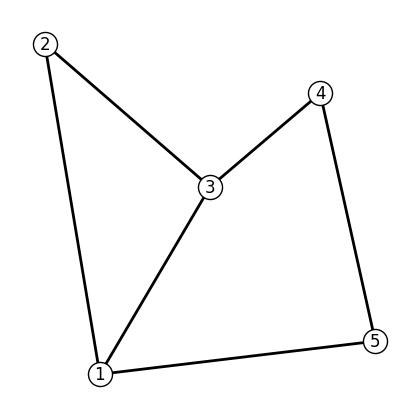

In [5]:
options = {
    "font_size": 12,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 2,
    "with_labels": True,    
}
plt.figure(figsize=(4,4))
nx.draw(G, pos, **options)
plt.axis("off")
plt.show()

The following cell turns the `nx_graph` created above into a GeometricKernels `GraphEdge` space --- the edge space of the graph.

The `incidence_matrix` parameter is a `numpy` array of shape `(n_nodes, n_edges)` where `n_nodes` is the number of nodes in the graph and `n_edges` is the number of edges in the graph. The entry `incidence_matrix[i, j]` is `-1` if node `i` is the source of edge `j`, `1` if node `i` is the target of edge `j`, and `0` otherwise. 

Note that: here we essentially consider the oriented incidence matrix, where the orientation of each edge can be user-defined. This will not affect the compuations.

This space essentially contains the Edge-Laplacian matrix, which is the Laplacian matrix of the edge space of the graph. In the general case, it is the Hodge-Laplacian matrix of the edge space of a simplicial 2-complex.


In [6]:
incidence_matrix = nx.incidence_matrix(G, oriented=True).toarray()
incidence_matrix = torch.tensor(incidence_matrix)
edge_graph = GraphEdge(incidence_matrix)
print('nodes:', G.nodes)
print('edges:', G.edges)
print('incidence matrix:\n', incidence_matrix)
print('\n')
print('edge Laplacian:\n', edge_graph.edge_laplacian)

nodes: [1, 2, 3, 5, 4]
edges: [(1, 2), (1, 3), (1, 5), (2, 3), (3, 4), (5, 4)]
incidence matrix:
 tensor([[-1., -1., -1.,  0.,  0.,  0.],
        [ 1.,  0.,  0., -1.,  0.,  0.],
        [ 0.,  1.,  0.,  1., -1.,  0.],
        [ 0.,  0.,  1.,  0.,  0., -1.],
        [ 0.,  0.,  0.,  0.,  1.,  1.]], dtype=torch.float64)


edge Laplacian:
 tensor([[ 2.,  1.,  1., -1.,  0.,  0.],
        [ 1.,  2.,  1.,  1., -1.,  0.],
        [ 1.,  1.,  2.,  0.,  0., -1.],
        [-1.,  1.,  0.,  2., -1.,  0.],
        [ 0., -1.,  0., -1.,  2.,  1.],
        [ 0.,  0., -1.,  0.,  1.,  2.]], dtype=torch.float64)


### Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `edge_graph` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel (*number of levels*).
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on graphs can be found on this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/graphs.html). **This is to be updated. I could write a brief documentation page on edge kernels.**

In [7]:
kernel = MaternGeometricKernel(edge_graph)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not provide the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [8]:
params = kernel.init_params()
print('params:', params)

params: {'nu': array([inf]), 'lengthscale': array([1.])}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params` we define below.

**Note:** unlike the Euclidean or the manifold case, the $1/2, 3/2, 5/2$ may fail to be the reasonable values of $\nu$.
On the other hand, the parameter $\nu$ is optimizable in the same way in which the legnthscale is.
Keep in mind though, that the optimization problem may require finding some trial and error to find good a initialization and that reasonable $\kappa$ and $\nu$ will heavily depend on the specific graph in a way that is hard to predict.


In [9]:
params["lengthscale"] = torch.tensor([2.0])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = torch.tensor([3/2])
params_inf["nu"] = torch.tensor([torch.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs (i.e., edges).

### Evaluating Kernels on Random Inputs

We start by sampling `3` (uniformly) random points on our graph.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [10]:
key = torch.Generator()
key.manual_seed(124)

key, xs = edge_graph.random(key, 3)

print(xs)

tensor([[4],
        [2],
        [1]], dtype=torch.int32)


Now we evaluate the two kernel matrices.

In [11]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

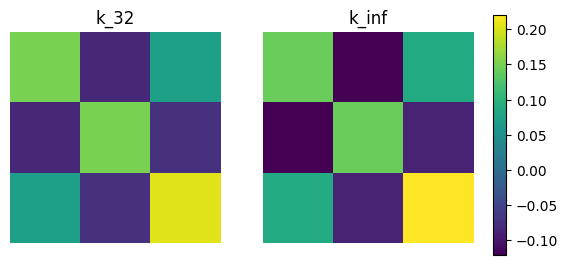

In [12]:
# find common range of values
minmin = min([torch.min(kernel_mat_32), torch.min(kernel_mat_inf)])
maxmax = max([torch.max(kernel_mat_32), torch.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualizing Kernels

Here we visualize $k_{\nu, \kappa}($ `base_edge` $, x)$ for $x \in $ `other_edges`.
We define `base_edge` and `other_edges` in the next cell.

In [13]:
base_edge = 1 # choosing a fixed edge for kernel visualization
other_edges = torch.arange(edge_graph.num_edges)[:, None]
edges = [e for e in G.edges()]

The next cell evaluates $k_{\nu, \kappa}($ `base_edge` $, x)$ for $x \in $ `other_edges` for $\nu$ either $3/2$ or $\infty$.

In [14]:
values_32  = kernel.K(params_32,  torch.tensor([[base_edge]]),
                              other_edges).flatten()
values_inf = kernel.K(params_inf, torch.tensor([[base_edge]]),
                              other_edges).flatten()

We also evaluate the variances $k_{\nu, \kappa}(x, x)$ for $x \in $ `other_edges` for $\nu$ either $3/2$ or $\infty$.

In [15]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = kernel.K_diag(params_32,  other_edges)
variance_inf = kernel.K_diag(params_inf, other_edges)

In [16]:
variance_32

tensor([0.1752, 0.2034, 0.1516, 0.1752, 0.1516, 0.1430], dtype=torch.float64)

Here are the actual visualization routines.

**Note:** the top right plot shows `k(base_edge, *)` where `*` goes through all nodes and `base_edge` has red outline. 

/home/mmaosheng/miniconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  node_collection = ax.scatter(


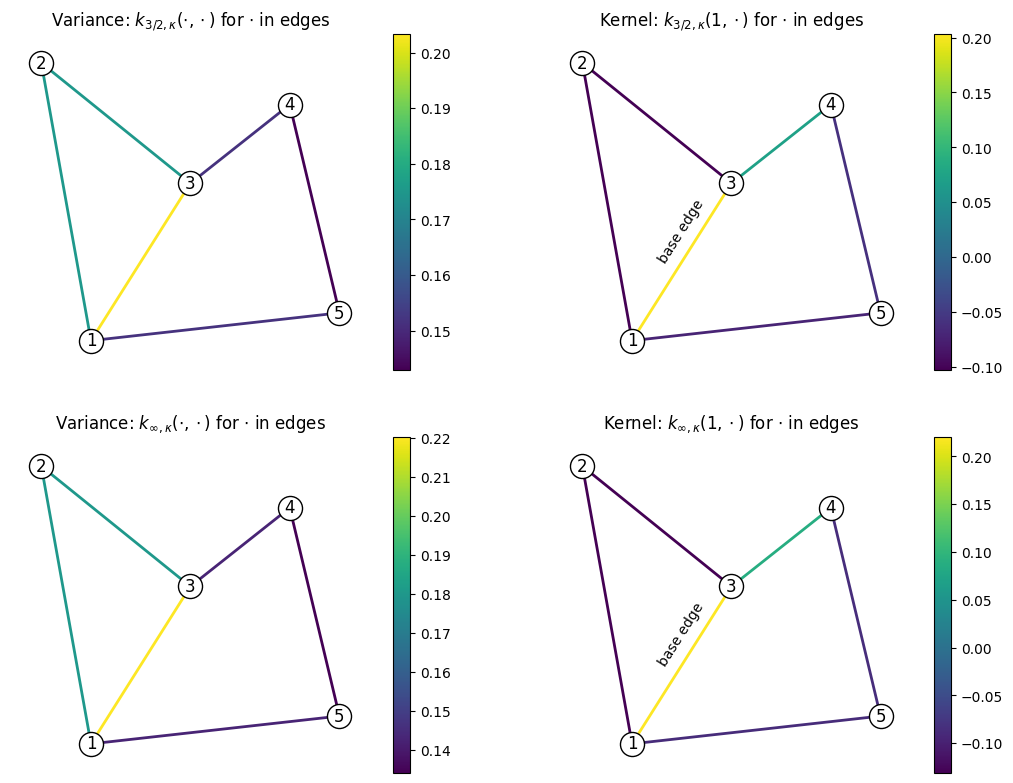

In [17]:
cmap = plt.get_cmap('viridis')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance 32
nx.draw(G, pos=pos, ax=ax1, cmap=cmap, edge_color=np.array(variance_32),
        vmin=variance_32.min(), vmax=values_32.max(),  **options)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=variance_32.min(), vmax=variance_32.max()))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: $k_{3/2, \kappa}(\cdot, \cdot)$ for $\cdot$ in edges')

# Plot kernel values 32
nx.draw(G, pos=pos, ax=ax2, cmap=cmap, edge_color=np.array(values_32),
        vmin=values_32.min(), vmax=values_32.max(), 
        **options)
# add a label at the base edge 
nx.draw_networkx_edge_labels(G, pos, edge_labels={(edges[base_edge][0], edges[base_edge][1]): 'base edge'}, verticalalignment='baseline', ax=ax2)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=values_32.min(), vmax=values_32.max()))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in edges' % base_edge)


# Plot variance inf
nx.draw(G, pos=pos, ax=ax3, cmap=cmap, edge_color=np.array(variance_inf),
        vmin=variance_inf.min(), vmax=variance_inf.max(), **options)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=variance_inf.min(), vmax=variance_inf.max()))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Variance: $k_{\infty, \kappa}(\cdot, \cdot)$ for $\cdot$ in edges')

# Plot kernel values inf
nx.draw(G, pos=pos, ax=ax4, cmap=cmap, edge_color=np.array(values_inf),
        vmin=values_inf.min(), vmax=values_inf.max(),
         **options)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(edges[base_edge][0], edges[base_edge][1]): 'base edge'}, verticalalignment='baseline', ax=ax4)

sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=values_inf.min(), vmax=values_inf.max()))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in edges' % base_edge)


plt.show()

### A Note on Prior Variance

Note that the **variance changes from edge to edge** on this graph.

For example, for the **unnormalized Edge Laplacian**, the variance is related to the expected *return time of a random walk*: how many steps, on average, does it take a particle
randomly walking over the edge space of the graph and starting in edge x to return back to edge x.
This argument is inspired by [Yang et al. 2024](https://arxiv.org/abs/2310.19450).

In [18]:
print('Variance in the edge (%d,%d) is %0.2f,' % (edges[0][0], edges[0][1], variance_32[0]))
print('Variance in the edge (%d,%d) is %0.2f,' % (edges[1][0], edges[1][1], variance_32[1]))
print('The average variance is %0.2f.' % torch.mean(variance_32))

Variance in the edge (1,2) is 0.18,
Variance in the edge (1,3) is 0.20,
The average variance is 0.17.


## Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on graphs, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

### Defining a Feature Map

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [19]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the edge sapce of graphs, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its **second** element is $\phi(x)$ evaluated at all inputs $x$.
Its first element is either `None` for determinstic feature maps, or contains the updated `key` for randomized feature maps which take `key` as a keyword argument.
For `default_feature_map` on a `GraphEdge` space, the first element is `None` since the feature map is *deterministic*.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [20]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = torch.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', torch.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = torch.Size([3, 1])):
tensor([[4],
        [2],
        [1]], dtype=torch.int32)

emedding (shape = torch.Size([3, 6])):
tensor([[-1.8151e-01,  2.8001e-01,  1.7556e-01,  3.2562e-02,  6.3360e-02,
          6.6133e-02],
        [ 1.8151e-01, -2.8001e-01,  1.7556e-01, -3.2562e-02,  6.3360e-02,
         -6.6133e-02],
        [ 1.8856e-01,  3.8734e-01, -7.2911e-17,  1.0537e-01,  7.5690e-17,
         -8.1745e-02]])

||k(xs, xs) - phi(xs) * phi(xs)^T|| = tensor(4.9422e-08)


### Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://geometric-kernels.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [21]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = torch.Generator()
key.manual_seed(1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
tensor([[-0.4017,  0.2195],
        [ 0.1529,  0.2334],
        [-0.3671,  0.2540]])


#### Visualizing Samples
Here we visualize samples as functions on the edges of a graph.

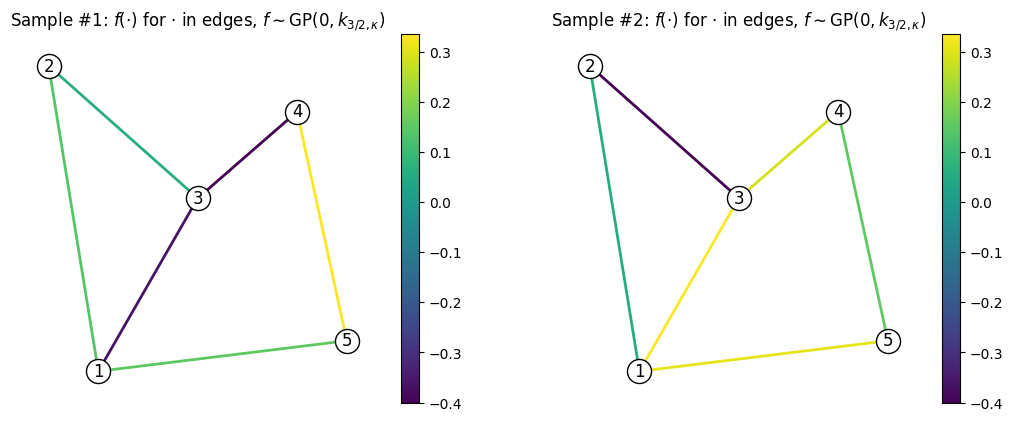

In [22]:
key = torch.Generator()
key.manual_seed(1234)
key, samples = sample_paths(other_edges, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(sample1.min(), sample2.min())
vmax = max(sample1.max(), sample2.max())
 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

# Plot sample #1
nx.draw(G, pos=pos, ax=ax1, cmap=cmap, edge_color=np.array(sample1),
        vmin=vmin, vmax=vmax, **options)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in edges, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Plot sample #2
nx.draw(G, pos=pos, ax=ax2, cmap=cmap, edge_color=np.array(sample2),
        vmin=vmin, vmax=vmax, **options)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in edges, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

plt.show()

## Citation

If you are using graphs and GeometricKernels, please consider citing

```
@article{mostowsky2024,
      title = {The GeometricKernels Package: Heat and Matérn Kernels for Geometric Learning on Manifolds, Meshes, and Graphs},
      author = {Peter Mostowsky and Vincent Dutordoir and Iskander Azangulov and Noémie Jaquier and Michael John Hutchinson and Aditya Ravuri and Leonel Rozo and Alexander Terenin and Viacheslav Borovitskiy},
      year = {2024},
      journal = {arXiv:2407.08086},
}
```

```
@InProceedings{pmlr-v238-yang24e,
  title = 	 {Hodge-Compositional Edge {G}aussian Processes},
  author =       {Yang, Maosheng and Borovitskiy, Viacheslav and Isufi, Elvin},
  booktitle = 	 {Proceedings of The 27th International Conference on Artificial Intelligence and Statistics},
  pages = 	 {3754--3762},
  year = 	 {2024},
  volume = 	 {238},
  series = 	 {Proceedings of Machine Learning Research},
  month = 	 {02--04 May},
  publisher =    {PMLR},
  pdf = 	 {https://proceedings.mlr.press/v238/yang24e/yang24e.pdf},
  url = 	 {https://proceedings.mlr.press/v238/yang24e.html}
}
```